# **PRÉ-PROCESSAMENTO**

In [ ]:
!pip install scikeras

In [6]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

**Retiramos algumas Features que não irão interferir no resultado final da rede neural**

In [3]:
df = pd.read_csv('autos.csv', encoding = 'ISO-8859-1')

df.drop(columns=["dateCrawled", "dateCreated", "nrOfPictures", "postalCode", "lastSeen", "name", "seller", "offerType"], axis=1, inplace=True)

**Retirei algumas outliers, pois alguns dados estão desconexos, exemplo, veículos de 11 milhões de Euros, 99 milhões de Euros, preço abaixo dos 10 Euros, etc.**

In [4]:
df = df[df["price"] > 10]
df = df[df["price"] < 350000]

**Substituindo o NaN das Features categóricas:**

In [6]:
ss = SimpleImputer(strategy="constant", fill_value="unknown")
ss.fit(df[["vehicleType", "gearbox", "model", "fuelType", "notRepairedDamage"]])

m = ss.transform(df[["vehicleType", "gearbox", "model", "fuelType", "notRepairedDamage"]])
df[["vehicleType", "gearbox", "model", "fuelType", "notRepairedDamage"]] = m

**Separando Features de Target:**

In [7]:
X = df.drop(columns=["price"])
y = df["price"]

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [12]:
#"abtest", "gearbox", "notRepairedDamage"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["abtest"]])


df["abtest"] = ohe.transform(df[["abtest"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [20]:
# "vehicleType", "model", "fuelType", "brand"
oe =  OrdinalEncoder()
oe.fit(df[["vehicleType"]])


df["vehicleType"] = oe.transform(df[["vehicleType"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [22]:
X = df.drop(columns=["price"])
y = df["price"]

In [23]:
ssc = StandardScaler()

ssc.fit(df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType','brand', 'notRepairedDamage']])
h= ssc.transform(df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType','brand', 'notRepairedDamage']])
df[['abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType','brand', 'notRepairedDamage']] = h

In [ ]:
df.columns

Index(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType',
       'brand', 'notRepairedDamage'],
      dtype='object')

# **DATASET BASE**

In [25]:
df

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,-0.965790,1.663185,-1.431118,-0.510428,-1.093903,0.161058,0.613007,-1.576977,-0.658132,1.323387,-0.328682
1,18300,-0.965790,-0.909188,0.976069,-0.510428,0.728149,1.610185,-0.015537,-0.219469,0.457815,-1.463578,3.042451
2,9800,-0.965790,1.148711,0.039940,1.959140,0.469226,0.175127,-0.015537,0.595035,0.457815,-0.484374,-0.328682
3,1500,-0.965790,-0.394713,-0.361257,-0.510428,-0.374672,0.161058,0.613007,0.052032,-0.658132,1.323387,-0.328682
4,3600,-0.965790,-0.394713,0.574871,-0.510428,-0.432210,-0.049980,-0.895499,0.323534,0.457815,0.796124,-0.328682
...,...,...,...,...,...,...,...,...,...,...,...,...
11398,1750,1.035422,0.634236,-1.029921,-0.510428,0.344559,-1.288070,0.613007,1.138038,-0.658132,-1.388254,-0.328682
11399,1199,1.035422,0.634236,-1.698584,-0.510428,-0.576057,0.161058,-0.895499,1.681041,-0.658132,1.323387,-0.328682
11400,5900,-0.965790,1.148711,-0.227525,-0.510428,-0.307544,0.273611,-1.649752,-1.033974,-0.658132,1.097417,-0.328682
11402,1999,-0.965790,0.119761,-0.093792,-0.510428,-0.125338,0.850448,0.613007,-0.219469,0.457815,1.323387,-0.328682


In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=6, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=6, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [10],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

In [35]:
grid_kr.best_params_

{'kr__batch_size': 10, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [32]:
grid_kr.best_score_

-2568.9474523413205

In [8]:
y_pred = grid_kr.predict(X_test)

NameError: ignored

In [34]:
y_pred

array([23998.66  ,  1805.3407,  2555.3848, ...,  3338.577 ,  7806.7065,
        4754.0703], dtype=float32)

In [36]:
tabela = pd.DataFrame()

In [37]:
tabela["Valor real"] = y_test

In [38]:
tabela["Valor preditivo"] = y_pred

In [39]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,0,480,1014.875671
1,3,1500,1575.382324
2,9,999,1238.156860
3,11,2799,2025.073242
4,13,2500,3197.461426
...,...,...,...
3306,11387,1250,1301.932739
3307,11390,350,1305.018188
3308,11392,1750,1721.942749
3309,11396,2099,1014.875671


In [40]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 64.82%


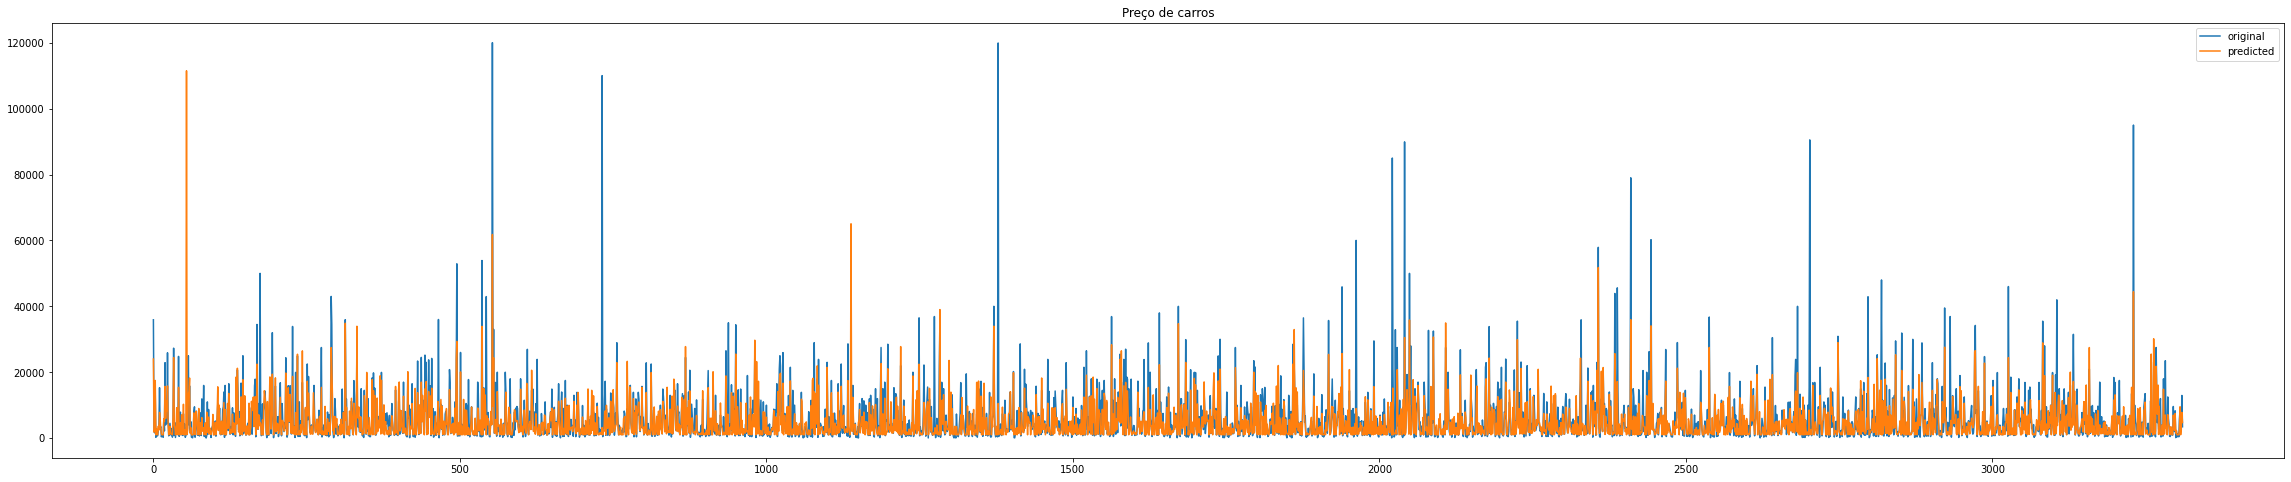

In [41]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Preço de carros")
plt.legend()
plt.show();

In [2]:
import pickle

In [43]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmpuezwsw6e/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpuezwsw6e/assets


In [11]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)

AttributeError: ignored